# A Simulation Study for Time-varying coefficients

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy import stats
from math import pi
from scipy.spatial.distance import cdist
import time

from orbit.models.ktrx import KTRXFull, KTRXAggregated
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data


plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

# Data Simulation Modules

In [48]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': np.sin(2*pi*tau),
        'beta3': np.sin(4*pi*(tau-1/8)),
        'x1': stats.chi2.rvs(4, size=n),
        'x2': stats.t.rvs(2, size=n),
        'x3': stats.t.rvs(2, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 1, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [49]:
seas_data = sim_data_seasonal(n=300, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.003333,2018-01-01,0.006667,0.020942,-0.999123,2.380312,-0.724116,-2.805017,1.000000,0.884191,3.687451
1,0.006667,2018-01-02,0.013333,0.041876,-0.996493,3.206075,-0.469831,0.724651,1.057633,0.009109,-0.689927
2,0.010000,2018-01-03,0.020000,0.062791,-0.992115,3.827392,0.151335,1.925227,0.891878,1.768186,-0.055809
3,0.013333,2018-01-04,0.026667,0.083678,-0.985996,14.764097,-0.271283,1.550322,0.967232,-1.507611,-2.665214
4,0.016667,2018-01-05,0.033333,0.104528,-0.978148,1.999616,-0.024061,0.113366,0.869799,-0.181936,-0.228686
5,0.020000,2018-01-06,0.040000,0.125333,-0.968583,3.583398,-0.559756,-1.477073,0.914509,-0.625022,0.878826
6,0.023333,2018-01-07,0.046667,0.146083,-0.957319,8.219563,-0.622302,-0.219984,0.818403,0.296977,0.800244
7,0.026667,2018-01-08,0.053333,0.166769,-0.944376,5.693641,-1.022237,-0.928416,0.764198,0.573434,1.583391
8,0.030000,2018-01-09,0.060000,0.187381,-0.929776,6.801100,1.463764,-1.764239,1.014435,0.805590,3.128286
9,0.033333,2018-01-10,0.066667,0.207912,-0.913545,5.710725,0.202612,-0.738096,1.043174,-0.971990,0.125135


In [50]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,0.111869,1.257944,-1.870548,0.083833,0.118039,0.106882,4.616809,2018-01-01
1,0.025149,0.530067,0.897456,0.081579,0.116649,0.116075,5.249795,2018-01-02
2,-1.253590,0.213434,0.422410,0.083838,0.112736,0.121694,4.843039,2018-01-03
3,-0.683038,0.309457,-0.192619,0.067788,0.111347,0.126284,4.823086,2018-01-04
4,-0.337015,0.389962,-0.308311,0.086333,0.099882,0.138985,5.527334,2018-01-05
5,-0.336446,-0.418615,1.314925,0.076195,0.108590,0.142555,5.055563,2018-01-06
6,-0.366356,-1.479541,-0.173128,0.091534,0.099006,0.156208,5.148542,2018-01-07
7,0.720599,-0.562337,-1.180655,0.100954,0.099507,0.160083,4.078918,2018-01-08
8,-0.364366,0.379963,-0.139817,0.100640,0.087954,0.163894,5.144474,2018-01-09
9,0.922233,0.169517,-0.089649,0.098496,0.085971,0.172410,4.720202,2018-01-10


In following section, let's start with random walk type of simulation.

# Random Walk Simulation Study

## KTRLite

**KTRLite** is used to learn the trend.  We will use a default to do that.

In [51]:
p = 3

In [52]:
# define stuff 
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
response_col = 'y'
# run the model 
# run lite first 
ktr_lite = KTRLiteMAP(
    response_col=response_col,
    date_col='date',
    seed=2020,
    estimator_type=StanEstimatorMAP,
)
ktr_lite.fit(df=rw_data)

level_knot_scale = ktr_lite.level_knot_scale
level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
level_knot_dates = ktr_lite._level_knot_dates
level_knots_stan = np.array([0] * len(level_knot_dates))

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [113]:
%%time
ktrx_neutral = KTRXFull(
       
    response_col=response_col,
    date_col='date',
    level_knot_scale=level_knot_scale,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),

    span_coefficients=0.1,
    rho_coefficients=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI, 
    
    # new setting we want to test
    mvn=0,
    flat_multiplier=True,
    geometric_walk=False,
    min_residuals_sd=1.0,
                                 
)

ktrx_neutral.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 7445.1, scale = 0.13865
step   50 loss = 684.55, scale = 0.19547
step  100 loss = 661.71, scale = 0.20912
step  150 loss = 661.67, scale = 0.20963
step  200 loss = 661.74, scale = 0.21166
step  250 loss = 661.96, scale = 0.20419
step  300 loss = 661.13, scale = 0.20837
step  350 loss = 661.42, scale = 0.20834
step  400 loss = 661.29, scale = 0.20845
step  450 loss = 661.41, scale = 0.21149
step  500 loss = 661.22, scale = 0.20711
CPU times: user 6.37 s, sys: 499 ms, total: 6.87 s
Wall time: 5.93 s


In [114]:
idx = 3

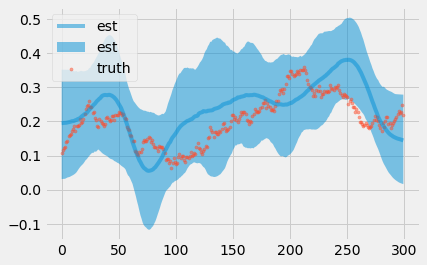

In [115]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True, coefficient_method='empirical')
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend()

In [ ]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [116]:
%%time
ktrx_pos = KTRXFull(
       
    response_col=response_col,
    date_col='date',
    level_knot_scale=level_knot_scale,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    span_coefficients=0.1,
    rho_coefficients=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI, 
    
    # new setting we want to test
    mvn=0,
    flat_multiplier=True,
    geometric_walk=False,
    min_residuals_sd=1.0,
                                 
)

ktrx_pos.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 7376.4, scale = 0.14222
step   50 loss = 697.57, scale = 0.55612
step  100 loss = 666.01, scale = 0.55796
step  150 loss = 662.26, scale = 0.55331
step  200 loss = 662.16, scale = 0.54842
step  250 loss = 662.12, scale = 0.54067
step  300 loss = 661.83, scale = 0.54603
step  350 loss = 661.65, scale = 0.54884
step  400 loss = 662.03, scale = 0.54575
step  450 loss = 662.53, scale = 0.55314
step  500 loss = 661.25, scale = 0.54899
CPU times: user 6.19 s, sys: 610 ms, total: 6.8 s
Wall time: 5.93 s


In [117]:
idx = 3

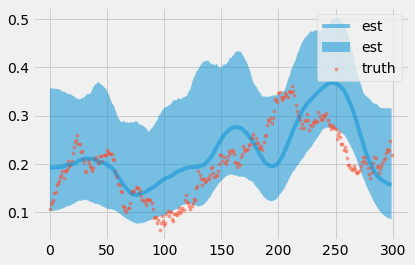

In [123]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True, coefficient_method='empirical')
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend()

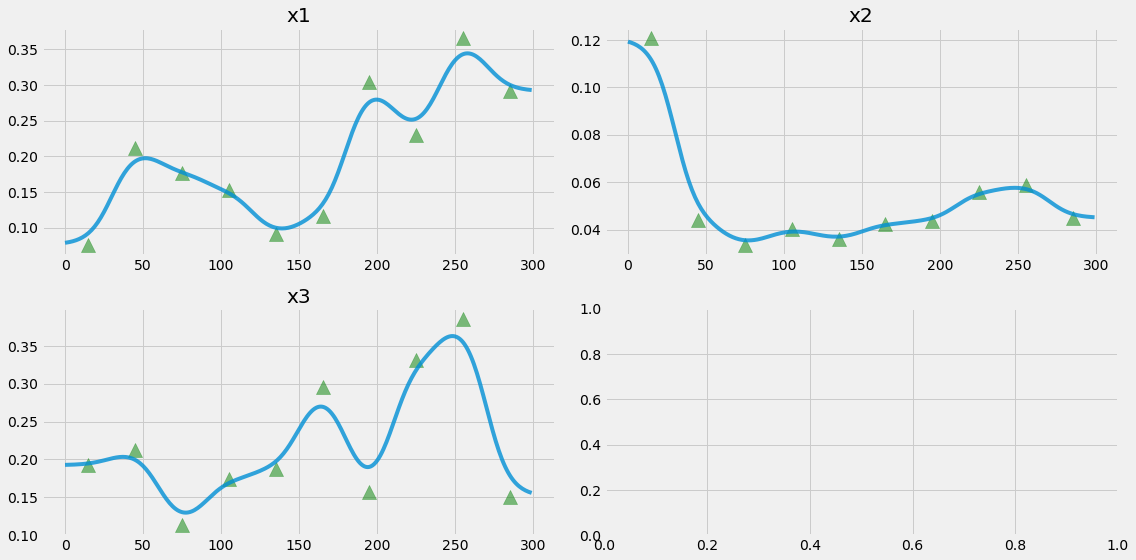

In [128]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Gemetric random walk structure with positive sign assumption and 

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [124]:
%%time
ktrx_grw = KTRXFull(
       
    response_col=response_col,
    date_col='date',
    level_knot_scale=level_knot_scale,
    level_knot_dates=level_knot_dates,
    level_knots=level_knots_stan,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    
    # since we turn geometric_walk to true, this setting also need to be changed from previous
    # i.e. scale parameter is interpreted differently
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[1.0] * len(regressor_col),
    regressor_sign=['+'] * len(regressor_col),

    span_coefficients=0.1,
    rho_coefficients=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI, 
    
    # new setting we want to test
    mvn=0,
    flat_multiplier=True,
    geometric_walk=True,
    min_residuals_sd=1.0,
                                 
)

ktrx_grw.fit(df=rw_data)                                  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 7153.6, scale = 0.12807
step   50 loss = 712.61, scale = 0.25939
step  100 loss = 664.95, scale = 0.42923
step  150 loss = 659.65, scale = 0.46434
step  200 loss = 657.05, scale = 0.47892
step  250 loss = 659.97, scale = 0.45562
step  300 loss = 656.05, scale = 0.45685
step  350 loss = 656.24, scale = 0.48421
step  400 loss = 658.82, scale = 0.4764
step  450 loss = 655.88, scale = 0.4954
step  500 loss = 656.05, scale = 0.49318
CPU times: user 6.23 s, sys: 464 ms, total: 6.69 s
Wall time: 5.83 s


In [125]:
idx = 3

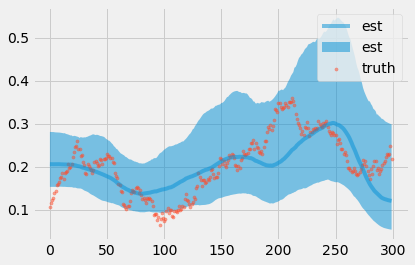

In [126]:
coef_mid, coef_lower, coef_upper  = ktrx_grw.get_regression_coefs(include_ci=True, coefficient_method='empirical')
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend()

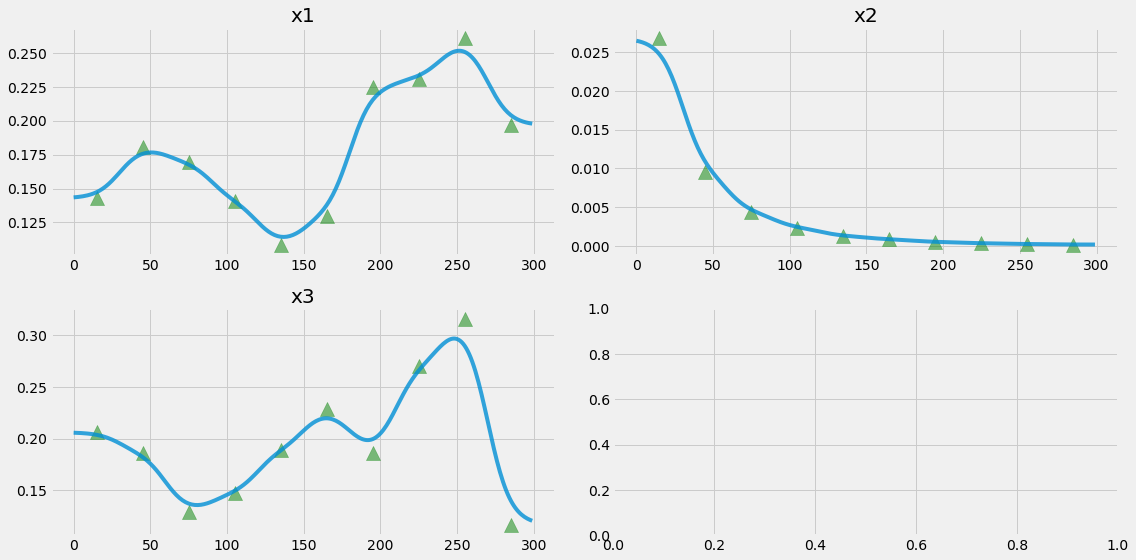

In [127]:
_ = ktrx_grw.plot_regression_coefs(with_knot=True, figsize=(16, 8))

In [12]:
idx = 3

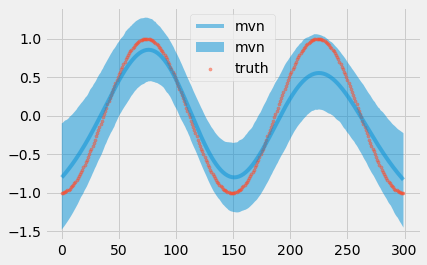

In [13]:
coef_mid, coef_lower, coef_upper  = ktrx1.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='mvn', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='mvn', alpha=0.5)
plt.scatter(x, data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend()

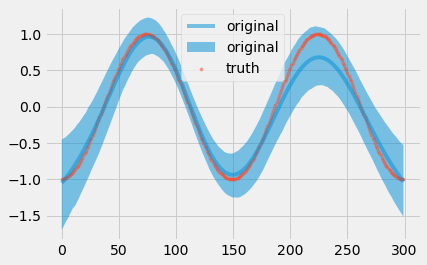

In [14]:
coef_mid, coef_lower, coef_upper  = ktrx2.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])
plt.plot(x, coef_mid['x{}'.format(idx)], label='original', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='original', alpha=0.5)
plt.scatter(x, data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend()

In [35]:
def multiple_test(N, n, sim_type):
    out = pd.DataFrame()
    out['index'] = range(0, N)
    # for hte model fit 
    out['time_1'] = 0.0
    out['time_2'] = 0.0
    
    out['SSE_1'] = 0.0
    out['SSE_2'] = 0.0
    out['RMSE_1'] = 0.0
    out['RMSE_2'] = 0.0
    out['max_error_1'] = 0.0
    out['max_error_2'] = 0.0
    
    # for the true values 
    out['SSE_beta1_1'] = 0.0
    out['SSE_beta1_2'] = 0.0 
    out['SSE_beta2_1'] = 0.0   
    out['SSE_beta2_2'] = 0.0
    out['SSE_beta3_1'] = 0.0
    out['SSE_beta3_2'] = 0.0

    
    for i in range(0, N):
        # simulate the data 
        if sim_type == 'sea':
            data = sim_data_seasonal(n = n, RS = 1000+i)
       
        if sim_type == 'rw':
            data = sim_data_rw(n = n, RS = 1000+i, p=3)    
    
        #print(data.head())
    
        # define stuff 
        regressor_col=['x1', 'x2', 'x3']
        response_col = 'y'
        # run the model 
        # run lite first 
        ktr_lite = KTRLiteMAP(
            response_col=response_col,
            date_col='date',
            level_knot_scale=1,
            seed=2000+i,
            span_level= .1, 
            estimator_type=StanEstimatorMAP,
        )
        ktr_lite.fit(df=data)
        level_knot_scale = ktr_lite.level_knot_scale
        level_knots_stan = ktr_lite._aggregate_posteriors['map']['lev_knot'][0]
        level_knot_dates = ktr_lite._level_knot_dates
        level_knots_stan = np.array([0] * len(level_knot_dates))
        
        ktrx1 = KTRXFull(
            response_col=response_col,
            date_col='date',

            degree_of_freedom=30,
            level_knot_scale=level_knot_scale,
            level_knot_dates=level_knot_dates,
            level_knots=level_knots_stan,

            regressor_col=regressor_col,
            regressor_knot_pooling_loc=[0] * len(regressor_col),
            regressor_knot_pooling_scale=[1] * len(regressor_col),
#             regressor_knot_scale=[1.0] * len(regressor_col),

            span_coefficients=0.1,
            rho_coefficients=0.1, 
            prediction_percentiles=[2.5, 97.5],
            seed=2000+i,
            num_steps=1000,
            num_sample=3000,
            verbose=False,
            message=100,
            n_bootstrap_draws=-1,
            estimator_type=PyroEstimatorVI,
            mvn=1
        )

        ktrx2 = KTRXFull(
            response_col=response_col,
            date_col='date',

            degree_of_freedom=30,
            level_knot_scale=level_knot_scale,
            level_knot_dates=level_knot_dates,
            level_knots=level_knots_stan,

            regressor_col=regressor_col,
            regressor_knot_pooling_loc=[0] * len(regressor_col),
            regressor_knot_pooling_scale=[1] * len(regressor_col),
            regressor_knot_scale=[1.0] * len(regressor_col),

            span_coefficients=0.1,
            rho_coefficients=0.1, 
            prediction_percentiles=[2.5, 97.5],
            seed=2000+i,
            num_steps=1000,
            num_sample=3000,
            verbose=False,
            message=100,
            n_bootstrap_draws=-1,
            estimator_type=PyroEstimatorVI,
        )
        
        # fit the models and recod the times
        start_time = time.time()
        ktrx1.fit(df=data)
        time_1 = time.time() - start_time
        
        start_time = time.time()
        ktrx2.fit(df=data)
        time_2 = time.time() - start_time
        
        # get the predictions 
        predicted_df_1 = ktrx1.predict(df=data)
        predicted_df_2 = ktrx2.predict(df=data)
            
        # compare to observations  
        SSE_1 = sum((predicted_df_1['prediction'] - data['y'])**2.0 )
        SSE_2 = sum((predicted_df_2['prediction'] - data['y'])**2.0 )
        
        max_misfit_1 = max(abs(predicted_df_1['prediction'] - data['y']) )
        max_misfit_2 = max(abs(predicted_df_2['prediction'] - data['y']) )
    
        out.at[i, 'time_1'] = time_1 
        out.at[i, 'time_2'] = time_2 
    
        out.at[i, 'SSE_1'] = SSE_1 
        out.at[i, 'SSE_2'] = SSE_2 
        
        out.at[i, 'RMSE_1'] = (SSE_1/n)**(0.5) 
        out.at[i, 'RMSE_2'] = (SSE_2/n)**(0.5) 
        
        
        out.at[i, 'max_error_1'] = max_misfit_1
        out.at[i, 'max_error_2'] = max_misfit_2
        
        #compare to true values 
        coef_df_1= ktrx1.get_regression_coefs(
        aggregate_method='median',
        include_ci=False)
        
        coef_df_2= ktrx2.get_regression_coefs(
        aggregate_method='median',
        include_ci=False)
        
        SSE_beta1_1 = sum((coef_df_1['x1']-data['beta1'])**2.0)
        SSE_beta2_1 = sum((coef_df_1['x2']-data['beta2'])**2.0)
        SSE_beta3_1 = sum((coef_df_1['x3']-data['beta3'])**2.0)
        SSE_beta1_2 = sum((coef_df_2['x1']-data['beta1'])**2.0)
        SSE_beta2_2 = sum((coef_df_2['x2']-data['beta2'])**2.0)
        SSE_beta3_2 = sum((coef_df_2['x3']-data['beta3'])**2.0)    
        
        out.at[i,'SSE_beta1_1'] = SSE_beta1_1
        out.at[i,'SSE_beta2_1'] = SSE_beta2_1
        out.at[i,'SSE_beta3_1'] = SSE_beta3_1
        out.at[i,'SSE_beta1_2'] = SSE_beta1_2
        out.at[i,'SSE_beta2_2'] = SSE_beta2_2
        out.at[i,'SSE_beta3_2'] = SSE_beta3_2
        
    return out


[autoreload of orbit.models.ktrx failed: Traceback (most recent call last):
  File "/Users/edwinng/work/venv/orbit-ktrx/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/edwinng/work/venv/orbit-ktrx/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/edwinng/.pyenv/versions/3.7.8/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/edwinng/.pyenv/versions/3.7.8/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, 

In [36]:
out = multiple_test(N=2, n=300, sim_type='sea')

TypeError: __init__() got an unexpected keyword argument 'regressor_knot_pooling_loc'

In [ ]:
multiple_test(N=3, n=300, sim_type='rw')